In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install iisignature
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import time
import iisignature
import h5py
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<h3>Used this notebook to help set up: </h3>

https://www.kaggle.com/code/ryzhokhina/harmful-brain-activity-visualization-data-cnn/notebook

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [17]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print(f'Train data shape = {train.shape}')
train.head(10)

Train data shape = (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [18]:
print(f'Count of unique patients: {len(train.patient_id.unique())}')
print(f'Count of unique spectrograms: {len(train.spectrogram_id.unique())}')
print(f'Count of unique EEGs: {len(train.eeg_id.unique())}')

Count of unique patients: 1950
Count of unique spectrograms: 11138
Count of unique EEGs: 17089


In [19]:
train_columns = ['eeg_id','eeg_sub_id','eeg_label_offset_seconds','spectrogram_id','spectrogram_sub_id','spectrogram_label_offset_seconds','label_id','patient_id']

<h2> Description of training set </h2> 

train.csv Metadata for the train set. The expert annotators reviewed 50 second long EEG samples plus matched spectrograms covering 10 a minute window centered at the same time and labeled the central 10 seconds. Many of these samples overlapped and have been consolidated. train.csv provides the metadata that allows you to extract the original subsets that the raters annotated.

1. eeg_id - A unique identifier for the entire EEG recording.

2. eeg_sub_id - An ID for the specific 50 second long subsample this row's labels apply to.

3. eeg_label_offset_seconds - The time between the beginning of the consolidated EEG and this subsample.

4. spectrogram_id - A unique identifier for the entire EEG recording.

5. spectrogram_sub_id - An ID for the specific 10 minute subsample this row's labels apply to.

6. spectogram_label_offset_seconds - The time between the beginning of the consolidated spectrogram and this subsample.

7. label_id - An ID for this set of labels.

8. patient_id - An ID for the patient who donated the data.

9. expert_consensus - The consensus annotator label. Provided for convenience only.

10. [seizure/lpd/gpd/lrda/grda/other]_vote - The count of annotator votes for a given brain activity class. The full names of the activity classes are as follows: lpd: lateralized periodic discharges, gpd: generalized periodic discharges, lrd: lateralized rhythmic delta activity, and grda: generalized rhythmic delta activity . A detailed explanations of these patterns is available here.

<h3> Description of training data </h3>

train_eegs/ EEG data from one or more overlapping samples. Use the metadata in train.csv to select specific annotated subsets. The column names are the names of the individual electrode locations for EEG leads, with one exception. The EKG column is for an electrocardiogram lead that records data from the heart. All of the EEG data (for both train and test) was collected at a frequency of 200 samples per second.

test_eegs/ Exactly 50 seconds of EEG data.

train_spectrograms/ Spectrograms assembled EEG data. Use the metadata in train.csv to select specific annotated subsets. The column names indicate the frequency in hertz and the recording regions of the EEG electrodes. The latter are abbreviated as LL = left lateral; RL = right lateral; LP = left parasagittal; RP = right parasagittal.

test_spectrograms/ Spectrograms assembled using exactly 10 minutes of EEG data.

<h2> EEG, Spectogram data example </h2>

These are where the Chains below come from:

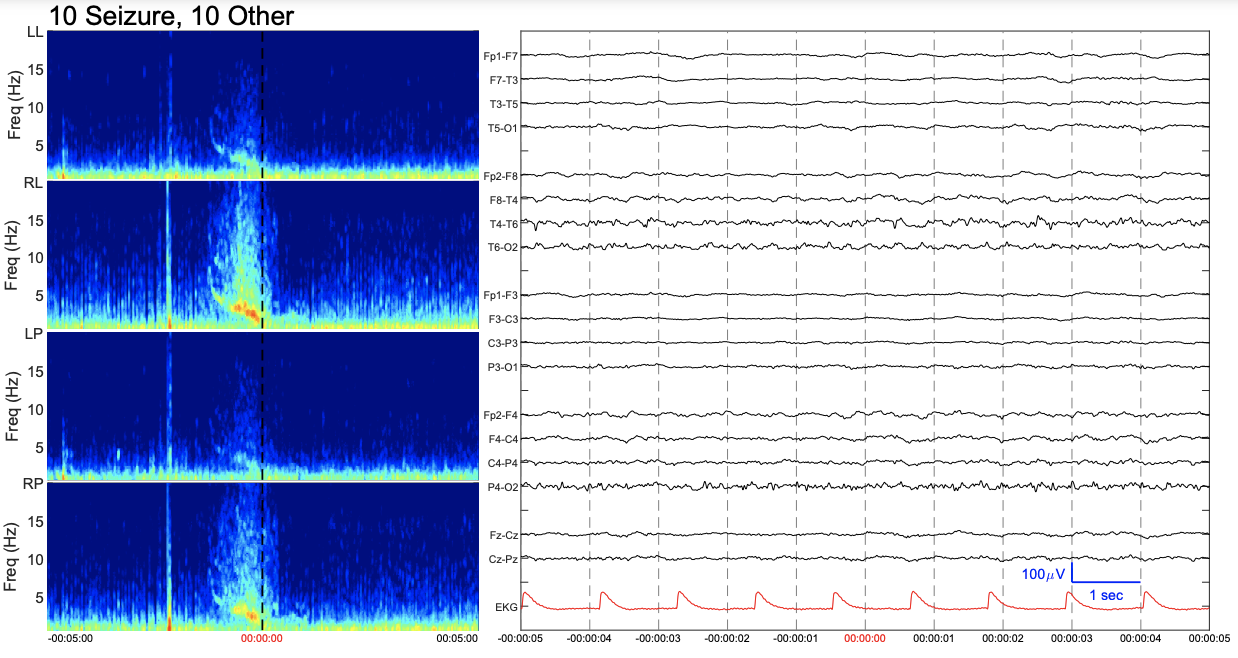

In [20]:
TARGET_COLUMNS = ['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']
CLASS_NAMES = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
LABEL2NAME = dict(enumerate(CLASS_NAMES))
NAME2LABEL = {v:k for k, v in LABEL2NAME.items()}

EEG_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
SP_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'

WIN_SIZE =  10 # 10 seconds
EEG_FR = 200 # 200 samples per seconds
EEG_T = WIN_SIZE*EEG_FR
CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")]
}
SP_WIN = 600 # 10 minutes = 600 seconds
EGG_WIN = 50 # 50 seconds in total

LABELED_SECS = 10

In [50]:
def get_eeg_sp_data(train_row):
    eeg_id = train_row.eeg_id
    sp_id = train_row.spectrogram_id
    
    eeg_parquet = pd.read_parquet(f'{EEG_PATH_TEMPL}{eeg_id}.parquet')
    sp_parquet = pd.read_parquet(f'{SP_PATH_TEMPL}{sp_id}.parquet')
    
    # offset of data
    eeg_offset = int(train_row.eeg_label_offset_seconds + 20) #only 10 central seconds from 50 secs were labeled, which should be seconds 20-30 in the sample
    sp_offset = int(train_row.spectrogram_label_offset_seconds )
    
    # get spectrogram data
    sp = sp_parquet.loc[(sp_parquet.time>=sp_offset)&(sp_parquet.time<sp_offset+SP_WIN)]
    sp = sp.loc[:, sp.columns != 'time']
    sp = {
        "LL": sp.filter(regex='^LL', axis=1),
        "RL": sp.filter(regex='^RL', axis=1),
        "RP": sp.filter(regex='^RP', axis=1),
        "LP": sp.filter(regex='^LP', axis=1)}
    
    # calculate eeg data
    eeg_data = eeg_parquet.iloc[eeg_offset*EEG_FR:(eeg_offset+WIN_SIZE)*EEG_FR]
    # print(eeg_data.keys()) # Has keys Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
                            # 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    # assert 0 == 1
    
    eeg = pd.DataFrame({})
    for chain in CHAINS.keys():
        for s_i, signals in enumerate(CHAINS[chain]):
            diff=eeg_data[signals[0]]-eeg_data[signals[1]] # Subtracts relevant fields as in the image above
            diff.ffill(inplace = True)
            eeg[f"{chain}: {signals[0]} - {signals[1]}"] = diff
    
    return eeg, sp, train_row[TARGET_COLUMNS].values


In [65]:
example_id = 4567
exp_row = train.iloc[example_id]
print(train.shape)
exp_row

(106800, 15)


eeg_id                              566655384
eeg_sub_id                                  0
eeg_label_offset_seconds                  0.0
spectrogram_id                       74252621
spectrogram_sub_id                         11
spectrogram_label_offset_seconds        388.0
label_id                            541052307
patient_id                               9693
expert_consensus                      Seizure
seizure_vote                                3
lpd_vote                                    0
gpd_vote                                    0
lrda_vote                                   0
grda_vote                                   0
other_vote                                  0
Name: 4567, dtype: object

In [53]:
eeg_data, sp_data, targets = get_eeg_sp_data(exp_row)
print(eeg_data.shape)

(2000, 16)


In [59]:


sig = iisignature.sig(eeg_data, 2)
print(sig.shape)

(272,)


In [71]:
start = time.time()
ids = range(100)
arr = []
for i in ids:
    exp_row = train.iloc[i]
    eeg_data, sp_data, targets = get_eeg_sp_data(exp_row)
    arr.append(eeg_data.to_numpy())
    
arr = np.array(arr)
end = time.time()
print(end - start)
sig = iisignature.sig(arr, 2)#
print(time.time() - end)
# print(sig.shape)


6.709693431854248
0.20726776123046875


In [76]:
# os.mkdir("hdf5")
h5f = h5py.File('hdf5/data.h5', 'w')
h5f.create_dataset('train_eeg_small', data=arr, compression="gzip")
h5f.close()

In [82]:
start = time.time()
hf = h5py.File('hdf5/data.h5', 'r')
data = hf.get('train_eeg_small')[:]
hf.close()
# print(data.shape)
end = time.time()
sig = iisignature.sig(arr, 2)#
print(time.time() - end)

0.24610471725463867


In [84]:
print(sig.shape)


(100, 272)


In [45]:
eeg_data['LL'][0].shape, sp_data['LL'].shape, targets

((2000,), (300, 100), array([3, 0, 0, 0, 0, 0], dtype=object))

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
 
# create objects

def plot_data(eeg_data, sp_data):
    fig, axes = plt.subplots(ncols=2, nrows=len(CHAINS)*4,figsize=(30, 40))
    
    time_x = np.arange(-5,5,1/200)
    x_ticks = np.arange(-5,5,1)
    
    for i, chain in enumerate(CHAINS):
        # plot eeg raw signals
        for j, dt in enumerate(eeg_data[chain]):
            ax = sns.lineplot(x=time_x, y=dt, ax=axes[i*4+j, 0])
            ax.set_xticks(x_ticks)
            ax.set_title(f'{CHAINS[chain][i][0]}-{CHAINS[chain][i][1]}')
            ax.grid(True) 
        
        # plot spectrogram
        gs = axes[i*4, 1].get_gridspec()
        axsbig = fig.add_subplot(gs[i*4:(i+1)*4, -1])
        log_spec = np.log(sp_data[chain].T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(sp_data[chain]), num=width, dtype=int)
        Y = range(height)
        axsbig.pcolormesh(X, Y, log_spec)
        axsbig.set_title(chain)
    fig.tight_layout()
    plt.show()

TARGET = [3 0 0 0 0 0]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

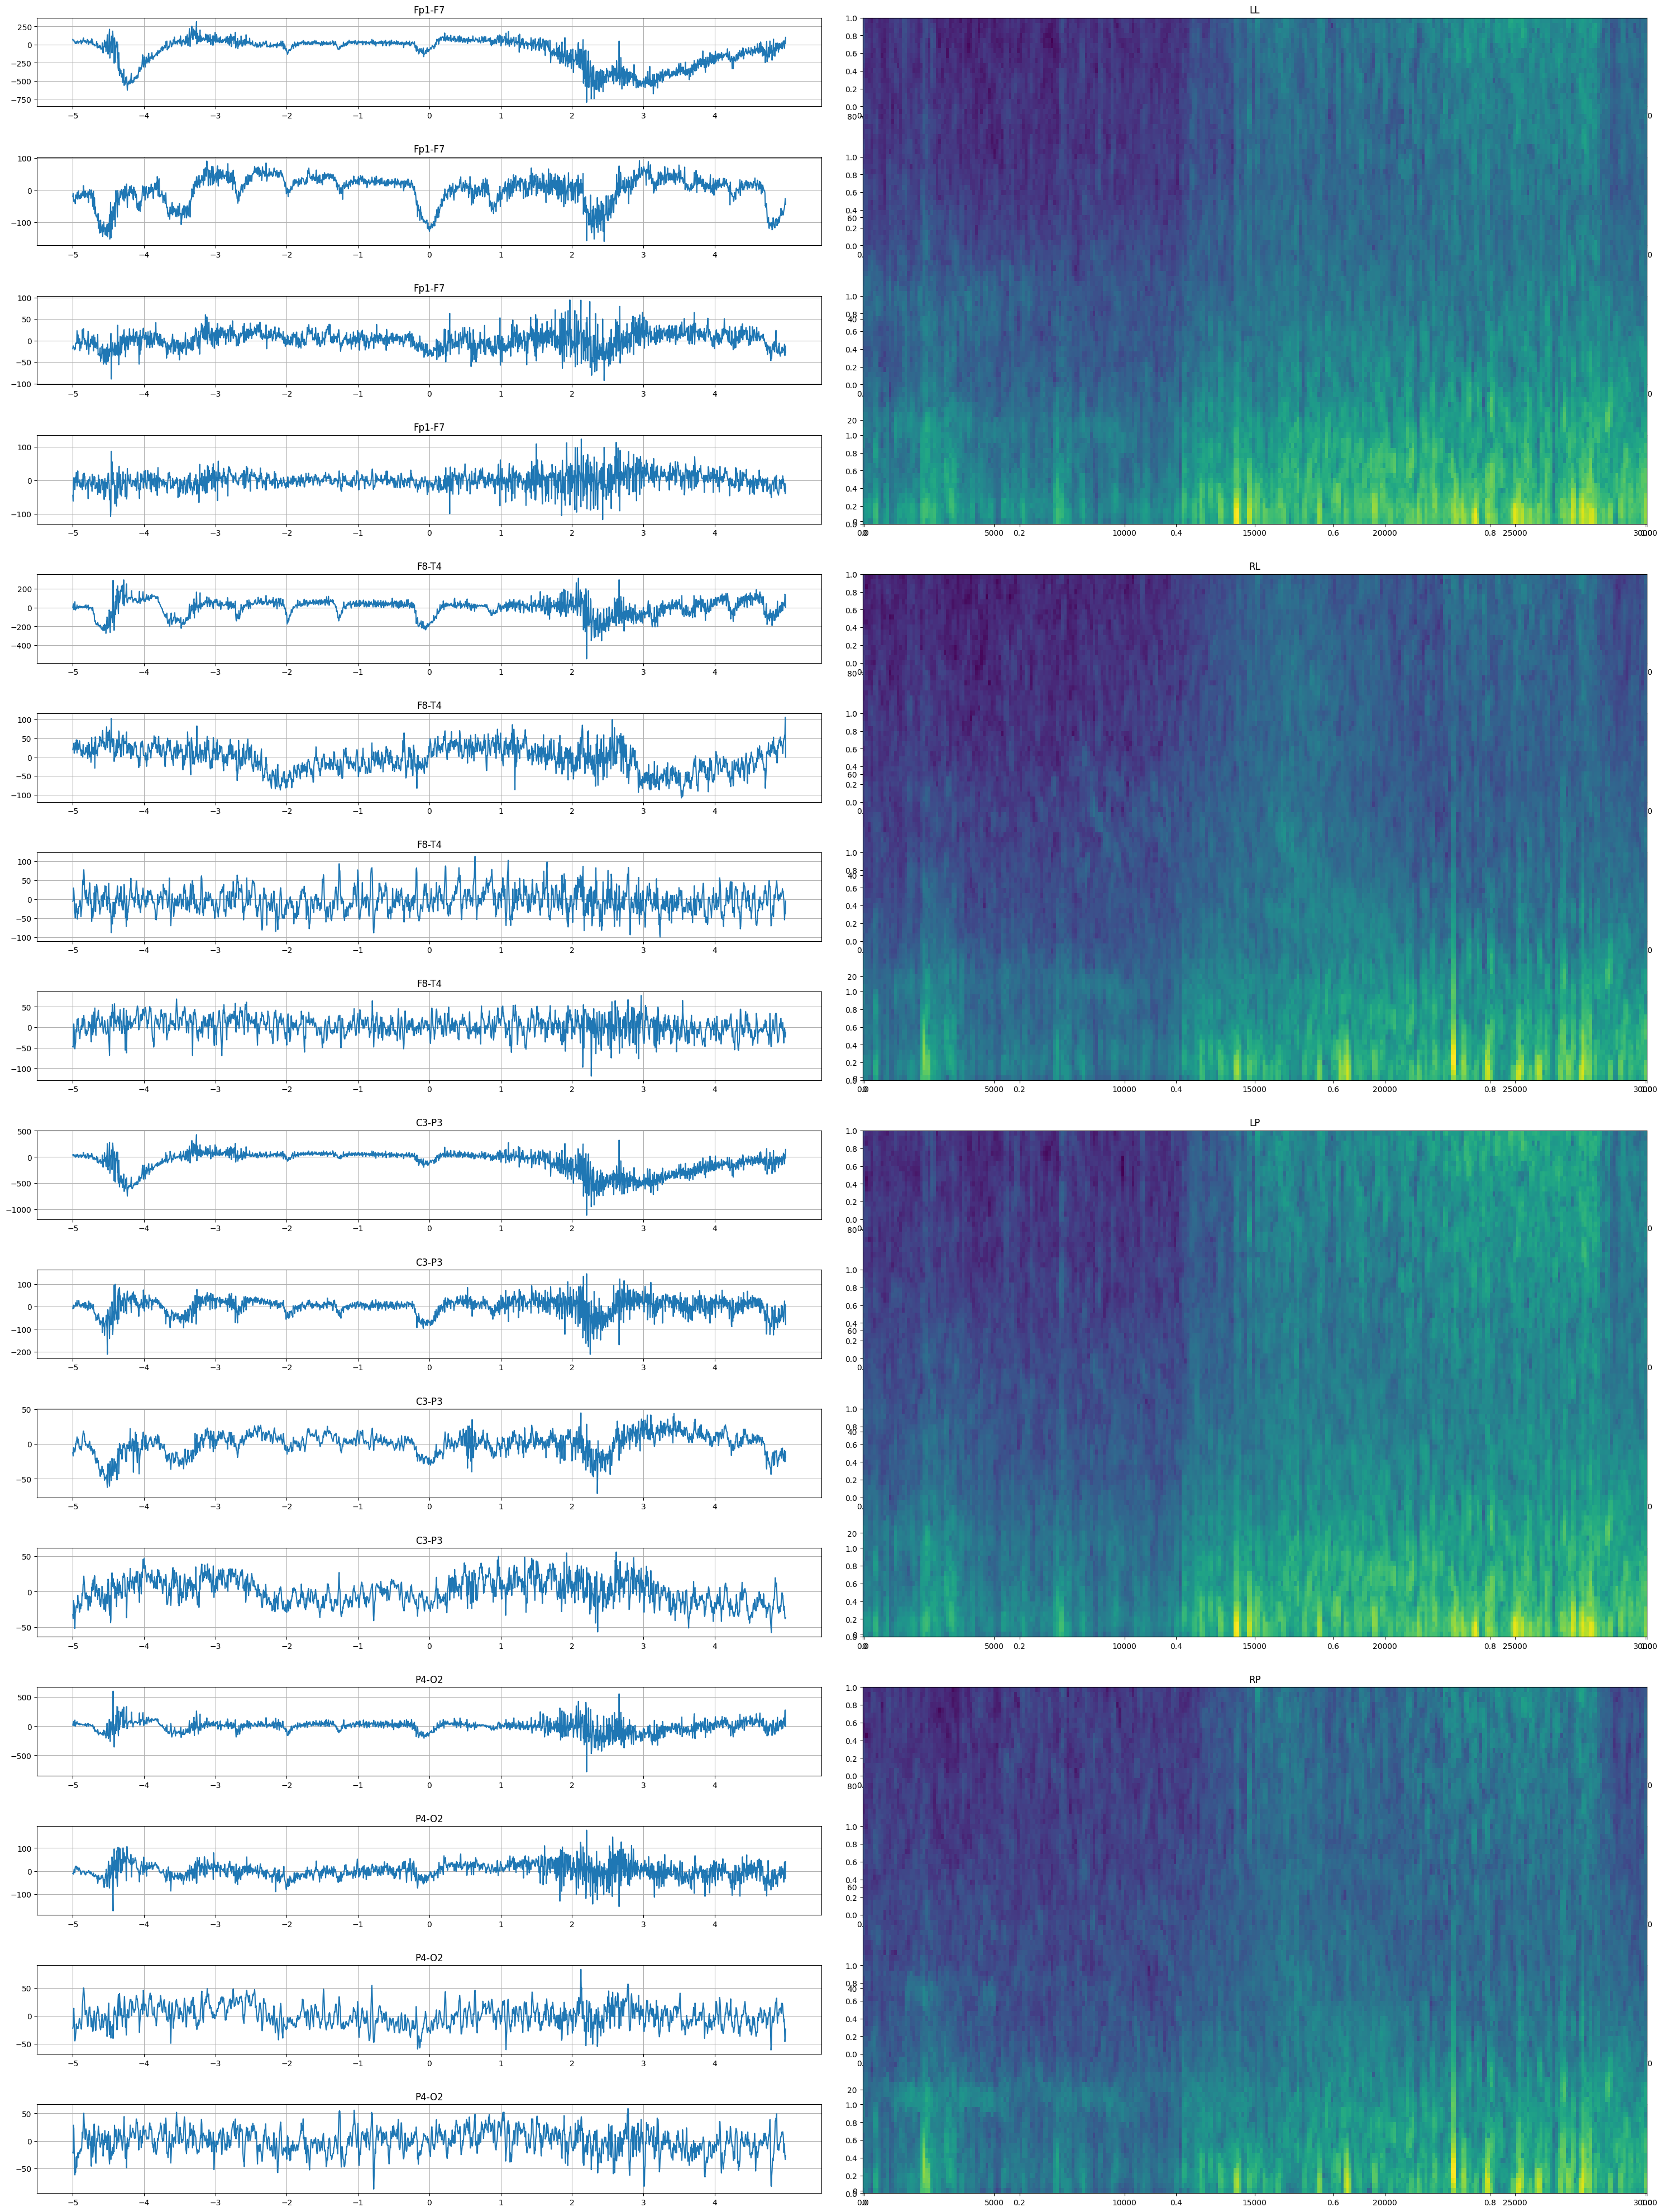

In [26]:
print(f'TARGET = {targets}')
plot_data(eeg_data, sp_data)

In [27]:
def plot_spectrogram(spectrogram, ax):
    assert len(spectrogram.shape) == 2   
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

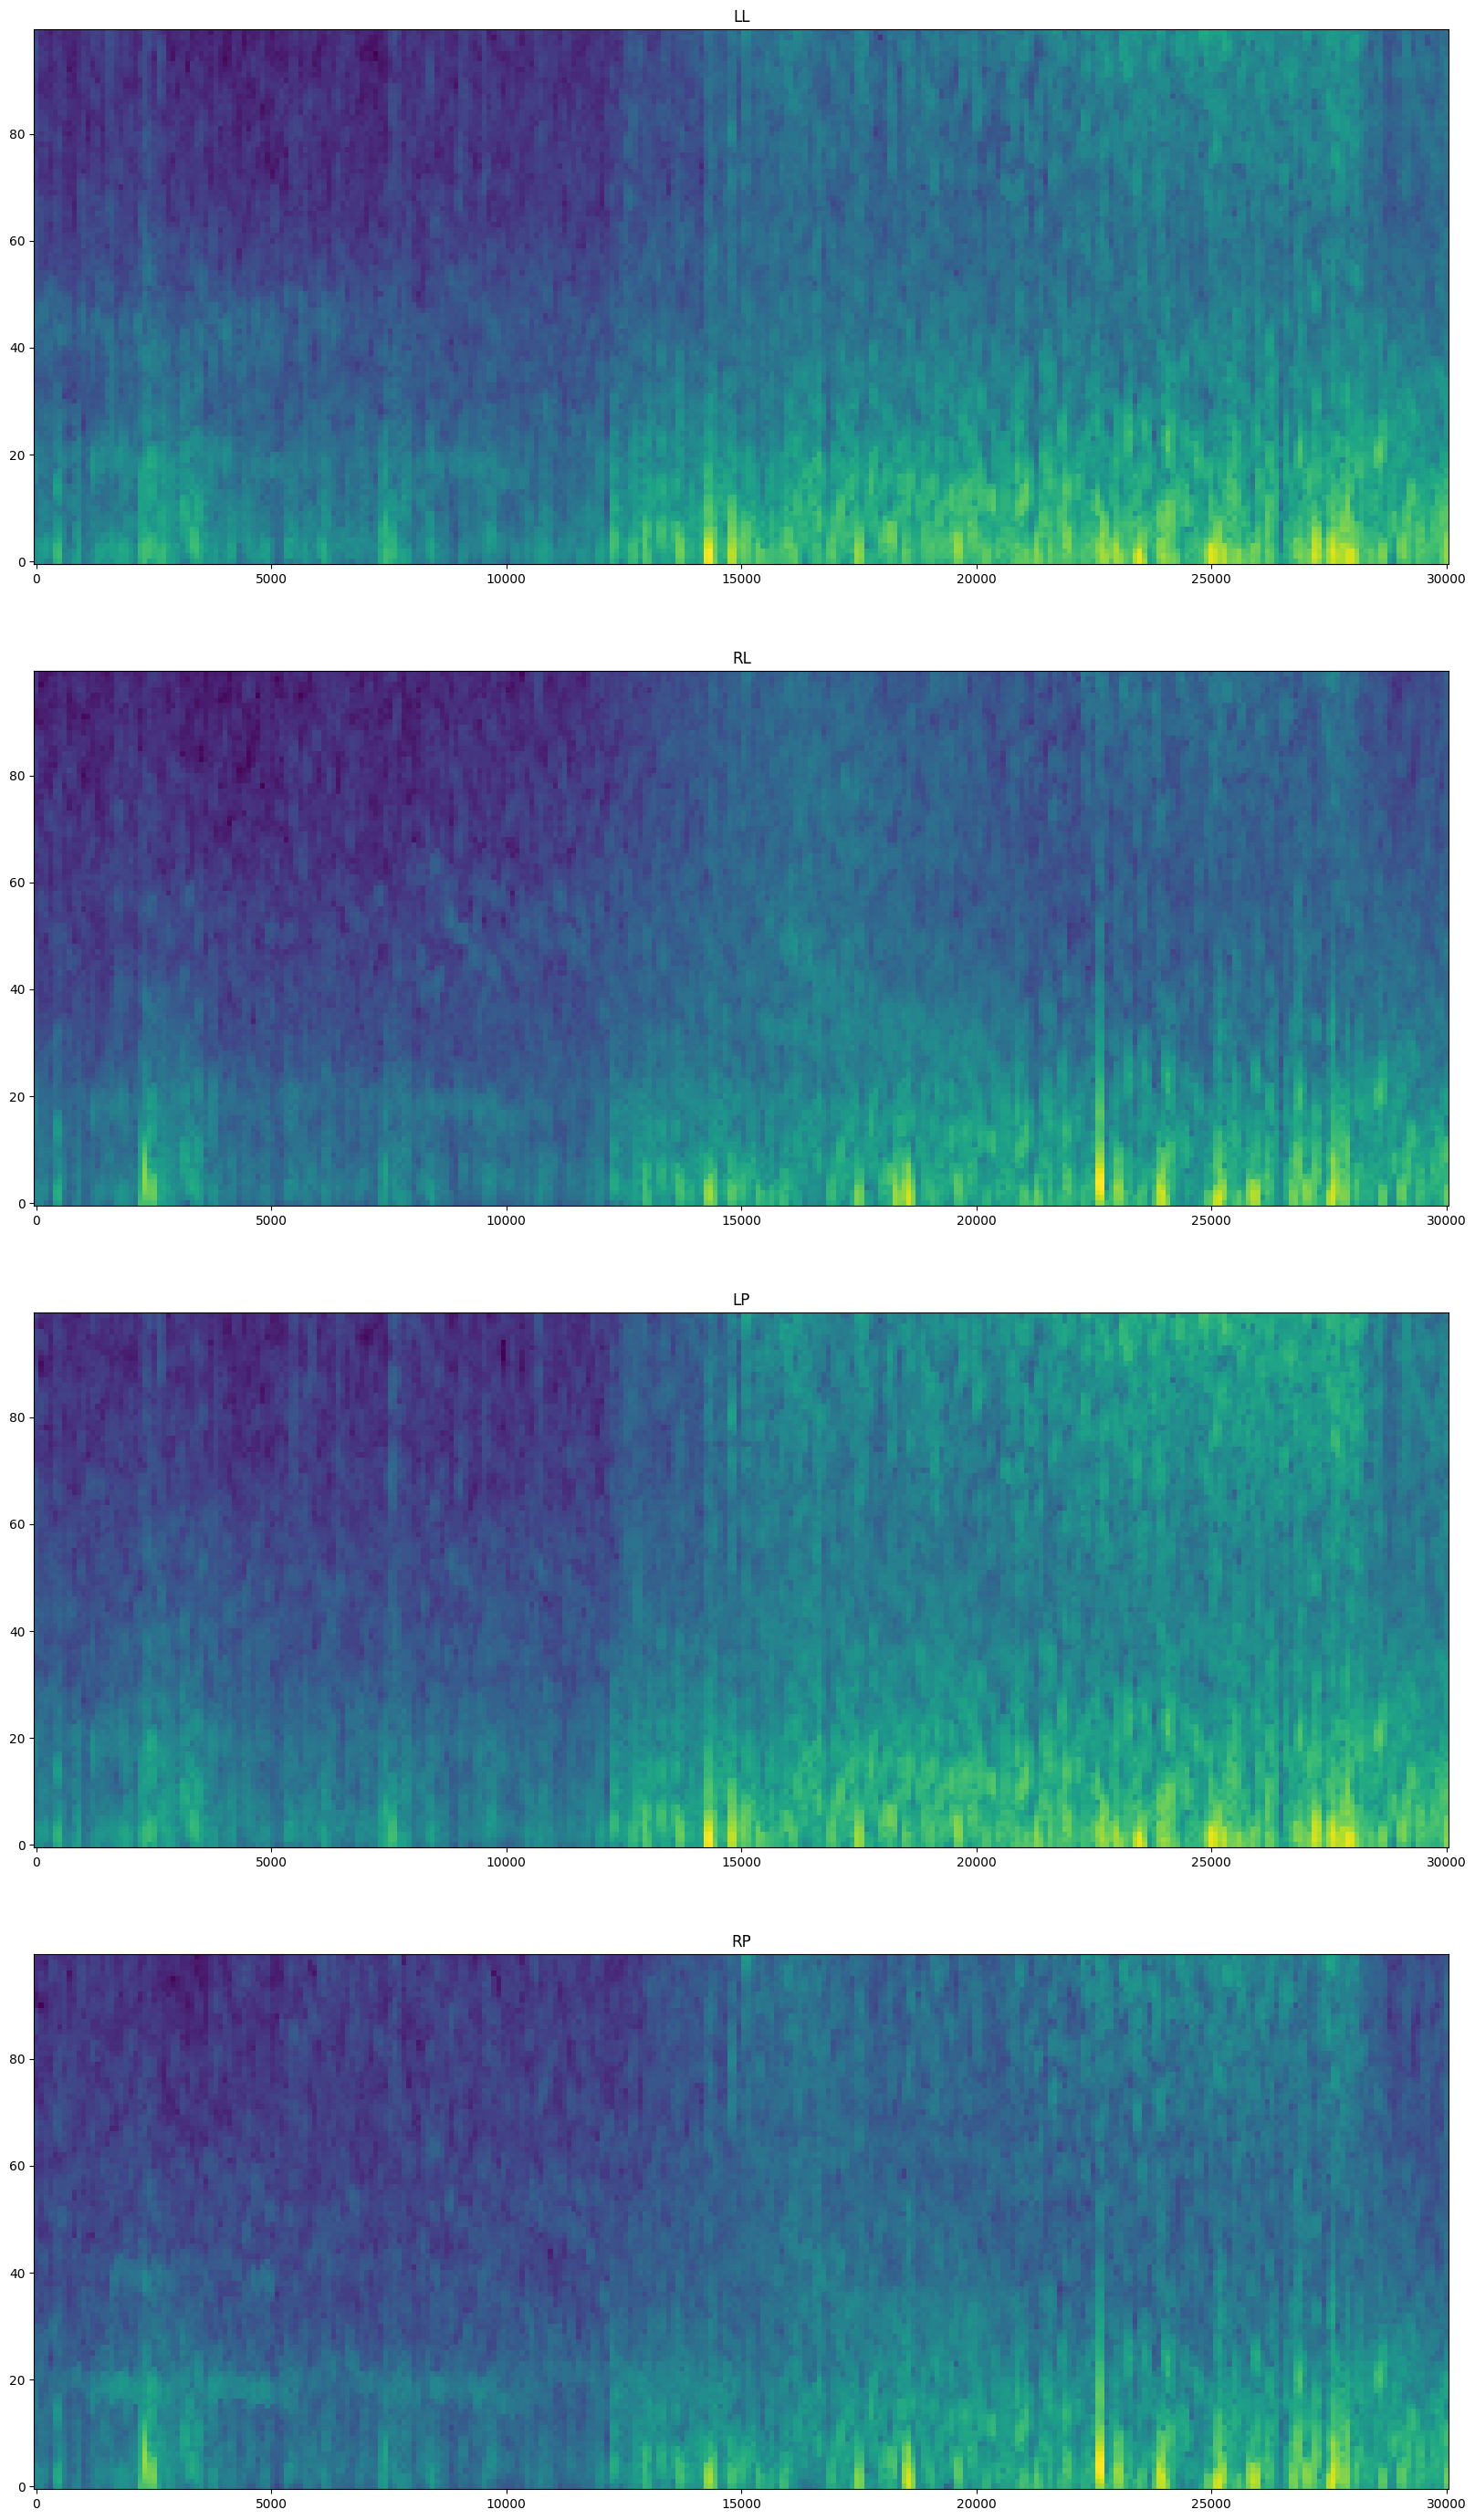

In [28]:
fig, axes = plt.subplots(4, figsize=(20, 35))
for i, chain in enumerate(CHAINS.keys()):
    plot_spectrogram(sp_data[chain], axes[i])
    axes[i].set_title(chain)
plt.show()